# Lab3
 - XGBoost
 - by 陈泽高 PB20000302

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as t

# Import Data

In [3]:
data = pd.read_csv("train.data",header=None)
data.shape

(7154, 41)

# XGBoosting model
    XGBoost
    Decision tree

In [4]:
class decision_tree:
    def __init__(self, depth=10):
        #self.dim = dim #只存在根节点即可
        self.maxdepth = depth
        self.is_leaf = True
    
    def fit_(self, X, g, lamb=0., gamma=0., delta=0.):#生成决策树
        [m, dim] = X.shape
        self.dim = dim  #只存在根节点即可

        Obj, w = self.Obj(g, lamb, gamma)

        self.fit(X, g, w, Obj, lamb, gamma, delta)

    def fit(self, X, g, w, Obj, lamb, gamma, delta):#
        '''生成决策树的后续流程 g:残差g=y w:预估权重 Obj:单叶得分'''
        if self.maxdepth<=0 or g.size<5:
            self.w = w
            self.penal = gamma + 1/2 *lamb* w*w
            #print(self.penal)
            return

        '''获取最佳划分及其得分'''
        a, Na, gain, wL, wR, ObjL, ObjR = self.get_attri(X, g, w, Obj, lamb, gamma, delta)

        if gain<=delta: # delta>0
            self.w = w
            self.penal = gamma + 1/2 *lamb* w*w
            #print(self.penal)
            return
        else:
            self.is_leaf = False
            self.attri = a
            self.Na = Na #判定属性及其阈值
            XL, XR, gL, gR= self.split(a, Na, X, g)
            self.Lchild = decision_tree(self.maxdepth-1)
            self.Rchild = decision_tree(self.maxdepth-1)
            self.Lchild.fit(XL, gL, wL, ObjL, lamb, gamma, delta)#wL
            self.Rchild.fit(XR, gR, wR, ObjR, lamb, gamma, delta)#wR
        
    def get_attri(self, X, g, w, Obj, lamb, gamma, delta):
        '''try to get the optimal attribute and point to split'''
        # gain = Obj(P) - Obj(L) - Obj(R) # Obj(P)=sum(g)^2*(...)+gamma
        [m, dim] = X.shape
        attri = 0
        [gain_max, Nattri, wL, wR, ObjL, ObjR] = [delta, 0., 0., 0., 0., 0.]

        for a in range(dim):
            g = g[X[:,a].argsort()]#按属性排序
            X = X[X[:,a].argsort()]
            '''s:等分参数，用于时间优化，内置为10~100'''
            s = 10
            for split in range(s-1):
                '''为了减少计算量，改为十等分'''
                if m>s:
                    Na = (X[int(m/s)*(split+1), a] + X[int(m/s)*(split+1)+1, a])/2
                elif split<m-1:
                    Na = (X[split, a] + X[split+1, a]) / 2            
                else:
                    continue        
                XL, XR, gL, gR = self.split(a, Na, X, g)
                if gL.size<=0 or gR.size<=0:
                    #print('skip')
                    continue
                ObjL_tmp, wL_tmp = self.Obj(gL, lamb, gamma)
                ObjR_tmp, wR_tmp = self.Obj(gR, lamb, gamma)
                
                #mL = gL.size
                #mR = gR.size
                #gain = - sum(g.reshape(m))*sum(g.reshape(m))/ (m) + sum(gL.reshape(mL))*sum(gL.reshape(mL))/ (mL)\
                #    + sum(gR.reshape(mR))*sum(gR.reshape(mR))/ (mR)
                
                gain = Obj - ObjL_tmp - ObjR_tmp
                #if gain<0:
                #    print(gain) 
                #else:
                #    print('yes!')
             
                if gain>gain_max:
                    #print(gain)
                    attri = a
                    gain_max = gain
                    Nattri = Na            
                    wL = wL_tmp
                    wR = wR_tmp
                    ObjL = ObjL_tmp
                    ObjR = ObjR_tmp

        return attri, Nattri, gain_max, wL, wR, ObjL, ObjR

    def Obj(self, g, lamb, gamma): #实际上与结点无关
        '''return the Obj and optimal weight of the node'''
        m = g.size
        '''公式检查点'''
        w = sum(g.reshape(m)) / (m + lamb/2)
        #print(w)
        Obj = - sum(g.reshape(m))*sum(g.reshape(m))/ (m + lamb/2) + gamma
        return Obj, w

    def Get_penal(self):
        '''获取树的惩罚项:叶子结点*gamma + |w|^2求和'''
        penal = 0.
        if self.is_leaf:
            penal = self.penal
        else:
            penal = self.Lchild.Get_penal() + self.Rchild.Get_penal()
        return penal
        
    def split(self, a, Na, X, g):
        XL = X[X[:,a]<Na,:]
        XR = X[X[:,a]>=Na,:]
        gL = g[X[:,a]<Na,:]
        gR = g[X[:,a]>=Na,:]
        return XL, XR, gL, gR
        
    def predict(self, x):
        if self.is_leaf:
            w_hat = self.w
        elif x[self.attri]<self.Na:
            w_hat = self.Lchild.predict(x)
        else:
            w_hat = self.Rchild.predict(x)
        return w_hat

    def predict_(self, X):
        m = X.shape[0]
        # y_hat VS w_hat
        w_hat = []
        for i in range(m):
            w_hat.append(self.predict(x=X[i,:]))
        return w_hat


In [5]:
class XGBoost_m: #避免重名
    def __init__(self, lamb=0., gamma=0., delta=0., tree_depth=10, tree_num_max=100):
        '''
        参数说明：lamb,gamma:正则项系数, delta:树停止条件, tree_depth:学习器深度上限, tree_num:学习器数量上限
        '''
        self.gamma = gamma
        self.lamb = lamb #lambda
        self.delta = delta
        self.tree_depth = tree_depth
        self.tree_num_max = tree_num_max
        self.forest = []

    def get_data(self, data):
        X = data[:,:-1]
        y = data[:,-1:]
        return X, y

    def boost(self, data):
        '''相当于fit，data包括X, y,返回loss(已有)和cost(loss + penalty)'''
        loss = []
        cost = []
        [m, dim] = data.shape
        dim -= 1
        X, y = self.get_data(data)
        y_ = y.copy()

        stop = False
        self.tree_num = 0
        while not stop:
            self.tree_num += 1
            self.forest.append(decision_tree(self.tree_depth))
            self.forest[self.tree_num - 1].fit_(X, y_, self.lamb, self.gamma, self.delta)

            y_ = y_ - np.array(self.forest[self.tree_num - 1].predict_(X)).reshape(m, 1)
            # loss/cost tracing
            loss.append((y_.T@y_)[0,0]) # 似乎这就是loss函数
            cost.append((y_.T@y_)[0,0] + self.penal())
            #print('final')#检查一下

            stop = self.if_stop(X, y)
            
        return loss, cost
    
    def if_stop(self, X, y):
        '''判断是否停止boosting。判据1：基学习器总数，判据2：待补充'''
        if self.tree_num >= self.tree_num_max:
            stop1 = True
        else:
            stop1 = False
        stop2 = False
        return stop1 or stop2

    def predict(self, x):
        y_hat = 0.
        for tree in self.forest:
            y_hat += tree.predict(x)
        return y_hat
    def predict_(self, X):
        m = X.shape[0]
        w_hat = []
        for i in range(m):
            w_hat.append(self.predict(X[i,:]))
        return w_hat    
    
    def loss_(self, data):
        X, y = self.get_data(data)
        return self.loss(X, y)    
    def loss(self, X, y):
        '''计算整个训练器的loss'''
        m = X.shape[0]
        y_hat = np.array(self.predict_(X)).reshape(m, 1)
        loss = (y_hat - y).T @ (y_hat - y)
        return loss[0,0]

    def penal(self):
        '''获取整个训练器的penalty'''
        penal = 0.
        for tree in self.forest:
            penal += tree.Get_penal()
        return penal
    
    def R_(self, data):
        X, y = self.get_data(data)
        return self.R(X, y)
    def R(self, X, y):
        '''计算R^2'''
        m = y.size
        MSE_m = (self.loss(X, y))
        y_mean = sum(y.reshape(m))/m
        Var_m = ((y-y_mean).T @ (y-y_mean))[0,0]
        R2 = 1 - MSE_m/Var_m
        return R2
    
    def RMSE_(self, data):
        X, y = self.get_data(data)
        return self.RMSE(X, y)
    def RMSE(self, X, y):
        m = y.size
        y_hat = np.array(self.predict_(X)).reshape(m, 1)
        MSE = (((y_hat - y).T @ (y_hat - y) / m) ** 0.5)[0,0]
        return MSE

# Fit & Train (example)

In [293]:
model = XGBoost_m(lamb=1,gamma=1e-8,delta=1e-8,tree_depth=4,tree_num_max=8)
train_data = data.values[:1000,:].copy()
loss, cost = model.boost(train_data)
print('over')

over


In [294]:
# showing costs and loss
for i in range(8):
    print(format(cost[i], '.4g'), format(loss[i], '.4g'))

3.794e-05 3.025e-05
2.929e-05 2.104e-05
2.731e-05 1.882e-05
2.526e-05 1.649e-05
2.386e-05 1.488e-05
2.272e-05 1.352e-05
2.181e-05 1.243e-05
2.112e-05 1.155e-05


In [295]:
# 训练集上的指标
R_2 = model.R_(data.values[:1000,:])
RMSE = model.RMSE_(data.values[:1000,:])
print(format(R_2, '.4g'), format(RMSE, '.4g'))

0.8853 0.0001075


In [296]:
# 测试集上的指标
R_2_test = model.R_(data.values[1000:1200,:])
RMSE_test = model.RMSE_(data.values[1000:1200,:])
print(format(R_2_test, '.4g'), format(RMSE_test, '.4g'))

0.5846 0.0002122


# Comparing parameters

In [12]:
lamb = 3
gamma = 1e-7
delta = 4e-7
tree_depth = 4
tree_num_max = 6

In [322]:
for lamb_t in range(5):
    model = XGBoost_m(lamb_t, gamma, delta, tree_depth, tree_num_max)
    train_data = data.values[:6000,:].copy()
    model.boost(train_data)
    R_2_test = model.R_(data.values[6000:,:])
    RMSE_test = model.RMSE_(data.values[6000:,:])
    print("lamb =", lamb_t, "R_2 =", format(R_2_test, '.4g'), "MSE =", format(RMSE_test, '.4g'))
    

lamb = 0 R_2 = 0.6487 MSE = 0.0002422
lamb = 1 R_2 = 0.6606 MSE = 0.0002381
lamb = 2 R_2 = 0.6738 MSE = 0.0002334
lamb = 3 R_2 = 0.6755 MSE = 0.0002328
lamb = 4 R_2 = 0.6757 MSE = 0.0002328


In [311]:
model = XGBoost_m(lamb, 0., delta, tree_depth, tree_num_max)
train_data = data.values[:6000,:].copy()
model.boost(train_data)
R_2_test = model.R_(data.values[6000:,:])
RMSE_test = model.RMSE_(data.values[6000:,:])
print("gamma =", 0, "R_2 =", format(R_2_test, '.4g'), "MSE =", format(RMSE_test, '.4g'))

for g in range(3):
    model = XGBoost_m(lamb, gamma*10**g, delta, tree_depth, tree_num_max)
    train_data = data.values[:6000,:].copy()
    model.boost(train_data)
    R_2_test = model.R_(data.values[6000:,:])
    RMSE_test = model.RMSE_(data.values[6000:,:])
    print("gamma =", gamma*10**g, "R_2 =", format(R_2_test, '.4g'), "MSE =", format(RMSE_test, '.4g'))
    

gamma = 0 R_2 = 0.6686 MSE = 0.0002353
gamma = 1e-08 R_2 = 0.6686 MSE = 0.0002353
gamma = 1e-07 R_2 = 0.673 MSE = 0.0002337
gamma = 1e-06 R_2 = 0.6348 MSE = 0.000247


In [320]:
for d in range(10):
    model = XGBoost_m(lamb, gamma, d*1e-7, tree_depth, tree_num_max)
    train_data = data.values[:6000,:].copy()
    model.boost(train_data)
    R_2_test = model.R_(data.values[6000:,:])
    RMSE_test = model.RMSE_(data.values[6000:,:])
    print("delta =", delta*10*d, "R_2 =", format(R_2_test, '.4g'), "RMSE =", format(RMSE_test, '.4g'))

delta = 0.0 R_2 = 0.673 RMSE = 0.0002337
delta = 1e-07 R_2 = 0.673 RMSE = 0.0002337
delta = 2e-07 R_2 = 0.6727 RMSE = 0.0002338
delta = 3e-07 R_2 = 0.6732 RMSE = 0.0002336
delta = 4e-07 R_2 = 0.6755 RMSE = 0.0002328
delta = 5e-07 R_2 = 0.6603 RMSE = 0.0002382
delta = 6e-07 R_2 = 0.6511 RMSE = 0.0002414
delta = 7e-07 R_2 = 0.6397 RMSE = 0.0002453
delta = 8e-07 R_2 = 0.6348 RMSE = 0.000247
delta = 9e-07 R_2 = 0.6348 RMSE = 0.000247


In [324]:
for depth in range(3, 8):
    model = XGBoost_m(lamb, gamma, delta, depth, tree_num_max)
    train_data = data.values[:6000,:].copy()
    model.boost(train_data)
    R_2_test = model.R_(data.values[6000:,:])
    RMSE_test = model.RMSE_(data.values[6000:,:])
    print("tree depth =", depth, "R_2 =", format(R_2_test, '.4g'), "RMSE =", format(RMSE_test, '.4g'))    

tree depth = 3 R_2 = 0.6707 RMSE = 0.0002346
tree depth = 4 R_2 = 0.6755 RMSE = 0.0002328
tree depth = 5 R_2 = 0.6676 RMSE = 0.0002357
tree depth = 6 R_2 = 0.6598 RMSE = 0.0002384
tree depth = 7 R_2 = 0.6646 RMSE = 0.0002367


In [13]:
for tree_num in range(5, 10):
    model = XGBoost_m(lamb, gamma, delta, tree_depth, tree_num)
    train_data = data.values[:6000,:].copy()
    model.boost(train_data)
    R_2_test = model.R_(data.values[6000:,:])
    RMSE_test = model.RMSE_(data.values[6000:,:])
    print("tree num =", tree_num, "R_2 =", format(R_2_test, '.4g'), "RMSE =", format(RMSE_test, '.4g'))  

tree depth = 5 R_2 = 0.6681 RMSE = 0.0002355
tree depth = 6 R_2 = 0.6755 RMSE = 0.0002328
tree depth = 7 R_2 = 0.6755 RMSE = 0.0002328
tree depth = 8 R_2 = 0.6755 RMSE = 0.0002328
tree depth = 9 R_2 = 0.6755 RMSE = 0.0002328


# show final result

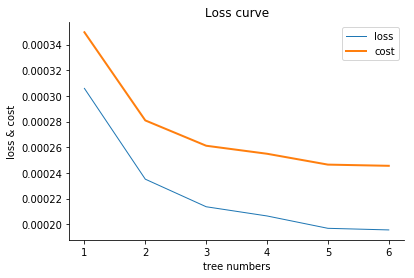

R_2 = 0.7701 RMSE = 0.0001958


In [11]:
dataset = data.values
np.random.shuffle(dataset)
#parameters
lamb = 4
gamma = 1e-7
delta = 4e-7
tree_depth = 4
tree_num_max = 6

model = XGBoost_m(lamb, gamma, delta, tree_depth, tree_num_max)
train_data = dataset[:6000,:]
loss, cost = model.boost(train_data)

#plot loss,cost
plt.figure()
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('tree numbers')
plt.ylabel('loss & cost')

plt.plot(range(1, len(loss)+1), loss, linewidth=1, linestyle="solid", label="train loss")
plt.plot(range(1, len(cost)+1), cost, linewidth=2, linestyle="solid", label="train cost")
ax.legend(['loss', 'cost'], loc='upper right')

plt.title('Loss curve')
plt.show()

#show R_2 and RMSE
R_2_test = model.R_(dataset[6000:,:])
RMSE_test = model.RMSE_(dataset[6000:,:])
print("R_2 =", format(R_2_test, '.4g'), "RMSE =", format(RMSE_test, '.4g'))

In [9]:
#多次验证
dataset = data.values
#parameters
lamb = 4
gamma = 1e-7
delta = 4e-7
tree_depth = 4
tree_num_max = 6

for i in range(10):
    np.random.shuffle(dataset)
    model = XGBoost_m(lamb, gamma, delta, tree_depth, tree_num_max)
    train_data = dataset[:6000,:]
    loss, cost = model.boost(train_data)

    #show R_2 and RMSE
    R_2_test = model.R_(dataset[6000:,:])
    RMSE_test = model.RMSE_(dataset[6000:,:])
    print("R_2 =", format(R_2_test, '.4g'), "RMSE =", format(RMSE_test, '.4g'))

R_2 = 0.7546 RMSE = 0.0001979
R_2 = 0.7868 RMSE = 0.00019
R_2 = 0.7704 RMSE = 0.0001966
R_2 = 0.7328 RMSE = 0.0002118
R_2 = 0.7637 RMSE = 0.0001996
R_2 = 0.7822 RMSE = 0.000195
R_2 = 0.7787 RMSE = 0.0001959
R_2 = 0.7973 RMSE = 0.0001986
R_2 = 0.7949 RMSE = 0.0001949
R_2 = 0.7755 RMSE = 0.0001974
